In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import math
import seaborn as sns
import sklearn
from sklearn import linear_model
from sklearn import preprocessing
%matplotlib inline
sns.set_style('white')

In [2]:
# Load the data. Keep air quality data, drop the index column and any missing data columns.

df = pd.read_csv(
    'https://vincentarelbundock.github.io/Rdatasets/csv/ISLR/Default.csv'
).iloc[:,1:].dropna()

# Recode strings to numeric.

df['default'] = np.where(df['default']=='Yes', 1, 0)
df['student'] = np.where(df['student']=='Yes', 1, 0)
names = df.columns
df = pd.DataFrame(preprocessing.scale(df), columns=names)

# Define the training and test sizes.

trainsize = int(df.shape[0] / 2)
df_test = df.iloc[trainsize:, :].copy()
df_train = df.iloc[:trainsize, :].copy()

Y_train = df_train['income'].values.reshape(-1, 1)
X_train = df_train.loc[:, ~(df_train.columns).isin(['income'])]

# Make some new features to capture potential quadratic and cubic relationships between solar radiation and day or temperature.

df_train['balance_student'] = df_train['balance'] * df_train['student']
df_train['balance_default'] = df_train['balance'] * df_train['default']
df_train['student_default'] = df_train['student'] * df_train['default']
df_train['balance_sqrt'] = (df_train['balance'] + 100) ** .5
df_train['balance2'] = (df_train['balance'] + 100) ** 2
df_train['balance3'] = (df_train['balance'] + 100) ** 3

X_train2 = df_train.loc[:, ~(df_train.columns).isin(['income'])]

# Test the simpler model with smaller coefficients.

Y_test = df_test['income'].values.reshape(-1, 1)
X_test = df_test.loc[:, ~(df_test.columns).isin(['income'])]

# Test the more complex model with larger coefficients.

df_test['balance_student'] = df_test['balance'] * df_test['student']
df_test['balance_default'] = df_test['balance'] * df_test['default']
df_test['student_default'] = df_test['student'] * df_test['default']
df_test['balance_sqrt'] = (df_test['balance'] + 100) ** .5
df_test['balance2'] = (df_test['balance'] + 100) ** 2
df_test['balance3'] = (df_test['balance'] + 100) ** 3

X_test2 = df_test.loc[:, ~(df_test.columns).isin(['income'])]

In [3]:
# Large number of parameters.

lassBig = linear_model.Lasso(alpha=.35)
lassBig.fit(X_train2, Y_train)
ridgeregrBig = linear_model.Ridge(alpha=10, fit_intercept=False)
ridgeregrBig.fit(X_train2, Y_train)

Ridge(alpha=10, copy_X=True, fit_intercept=False, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [4]:
# Prepare Ridge Regression for graph

# Store estimates.
scoresR = np.append(ridgeregrBig.score(X_test2, Y_test),[0])

# Run the Ridge model for many alphas.
for lambd in [x  for x in range(0, 1000)]:
    ridgeregrBig = linear_model.Ridge(alpha=lambd, fit_intercept=False)
    ridgeregrBig.fit(X_train2, Y_train)
    scoresR = np.row_stack((
        scoresR,
        np.append([ridgeregrBig.score(X_test2, Y_test),],[lambd])))

# Make the data pretty.

scoresR_df = pd.DataFrame(
     scoresR,columns = ['R2Ridge','lambd'])
scoresR_df.sort_values(by='lambd', inplace=True, ascending=True)


In [5]:
# Prepare Lasso Regression for graph

# Store estimates.
scoresL = np.append(lassBig.score(X_test2, Y_test),[0])

#Run the model for many alphas.
for lambd in [x * 0.01 for x in range(1, 1000)]:
    lassBig = linear_model.Lasso(alpha=lambd)
    lassBig.fit(X_train2, Y_train)
    scoresL = np.row_stack((
        scoresL,
        np.append(lassBig.score(X_test2, Y_test),[lambd])))

#Make the data pretty.
scoresL_df = pd.DataFrame(
    scoresL,columns = ['R2Lasso','lambda'])
scoresL_df.sort_values(by='lambda', inplace=True, ascending=True)


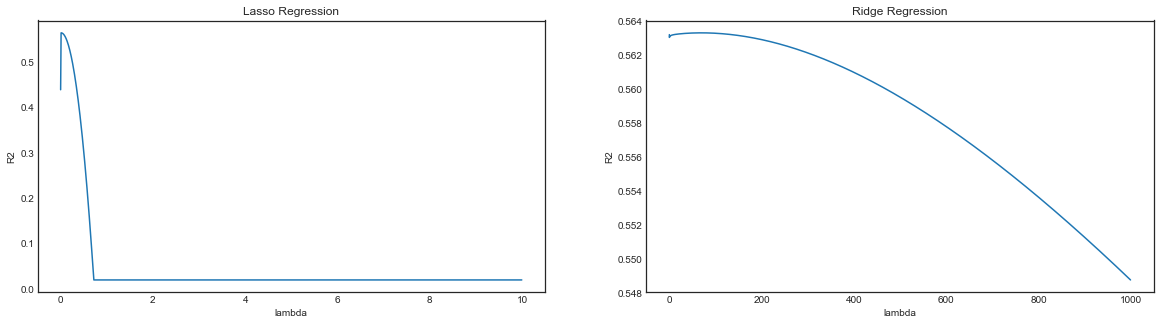

In [6]:
# Plot both graphs Ridge & Lasso

plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
plt.plot(scoresL_df['lambda'], scoresL_df['R2Lasso'])
plt.title('Lasso Regression')
plt.xlabel('lambda')
plt.ylabel('R2')


plt.subplot(1, 2, 2)
plt.plot(scoresR_df['lambd'], scoresR_df['R2Ridge'])
plt.title('Ridge Regression')
plt.xlabel('lambda')
plt.ylabel('R2')

plt.show()

The R2 values in each case are different per every lambda value. In the case of the Lasso regression R2 value decreases faster than in the case of Ridge regression. Ridge regression remains between 0.54 and 056 for the first 1000 values of lambda